In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion

In [2]:
df = pd.read_csv('./train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [6]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [7]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')

Best Threshold=0.3869370891147378, F-Score= 0.730, Precision= 0.647, Recall= 0.838


In [8]:
def roc_auc_plot(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.text(0,1,f'ROC-AUC_SCORE{roc_auc_score(y_test,y_score): .3f}')
    #plt.savefig("ROC.png")
    plt.show()

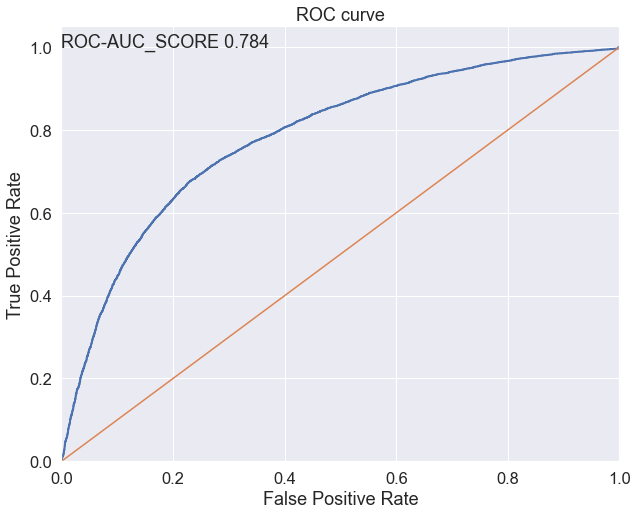

In [9]:
roc_auc_plot(y_test, y_score)

In [10]:
my_dict={
    'model':['LogReg'],
    'F-score':[fscore[ix]],
    'Precision':[precision[ix]],
    'Recall':[recall[ix]],
    'ROC-AUC-SCORE':[roc_auc_score(y_test, y_score)]
}

In [11]:
my_dict

{'model': ['LogReg'],
 'F-score': [0.7303229695112764],
 'Precision': [0.6474307596402173],
 'Recall': [0.8375576036866359],
 'ROC-AUC-SCORE': [0.7840347790421852]}

In [12]:
clf = RandomForestClassifier()
parametrs = { 'n_estimators': range (10, 100, 10),
              'max_depth': range (1,20, 2)
              }
grid = GridSearchCV(clf, parametrs, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)
grid.best_params_


{'max_depth': 11, 'n_estimators': 80}

In [13]:
classifier_forest = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=80, max_depth=11, random_state=0))])

In [14]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_forest, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

#обучим пайплайн на всем тренировочном датасете
classifier_forest.fit(X_train, y_train)
y_score_forest = classifier_forest.predict_proba(X_test)[:, 1]

CV score is 0.8014685864672031+-0.007051282899991303


In [15]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_forest)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
new_list=['Forest',fscore[ix],precision[ix], recall[ix], roc_auc_score(y_test, y_score_forest)]
for i, (key, val) in enumerate(my_dict.items()):
    my_dict[key].append(new_list[i])

Best Threshold=0.34067632217172195, F-Score= 0.740, Precision= 0.655, Recall= 0.851


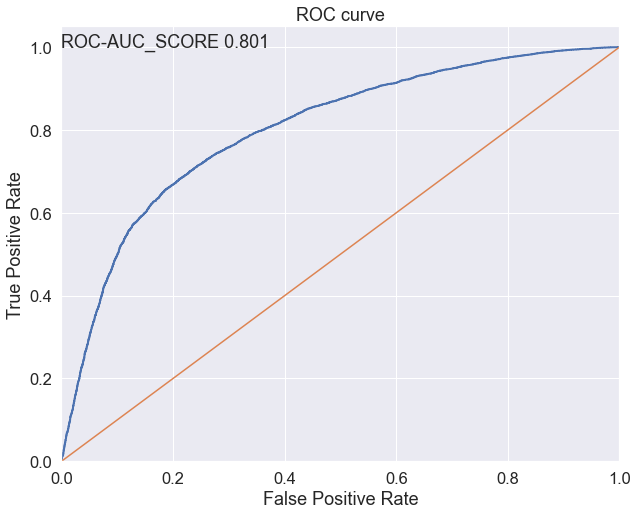

In [16]:
roc_auc_plot(y_test, y_score_forest)

In [17]:
my_dict

{'model': ['LogReg', 'Forest'],
 'F-score': [0.7303229695112764, 0.7403956924618081],
 'Precision': [0.6474307596402173, 0.6549401860877271],
 'Recall': [0.8375576036866359, 0.8514976958525345],
 'ROC-AUC-SCORE': [0.7840347790421852, 0.8014207145992038]}

In [21]:
clf_2 = GradientBoostingClassifier()
parametrs_2 = {'n_estimators': range (10, 100, 10),
              'max_depth': range (1,20, 2)
              }
grid_2 = GridSearchCV(clf_2, parametrs_2, scoring='roc_auc', cv=5)
grid_2.fit(X_train, y_train)
grid_2.best_params_


{'max_depth': 5, 'n_estimators': 40}

In [22]:
classifier_boost = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier( max_depth=5, n_estimators=40,random_state=0 ))])

In [23]:
cv_scores = cross_val_score(classifier_boost, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

CV score is 0.8025352491126763+-0.006713005693958993


In [24]:
classifier_boost.fit(X_train, y_train)
y_score_boost = classifier_boost.predict_proba(X_test)[:, 1]

In [25]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_boost)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
new_list=['GradBoost',fscore[ix],precision[ix], recall[ix], roc_auc_score(y_test, y_score_boost)]
for i, (key, val) in enumerate(my_dict.items()):
    my_dict[key].append(new_list[i])

Best Threshold=0.3573983776589348, F-Score= 0.740, Precision= 0.667, Recall= 0.831


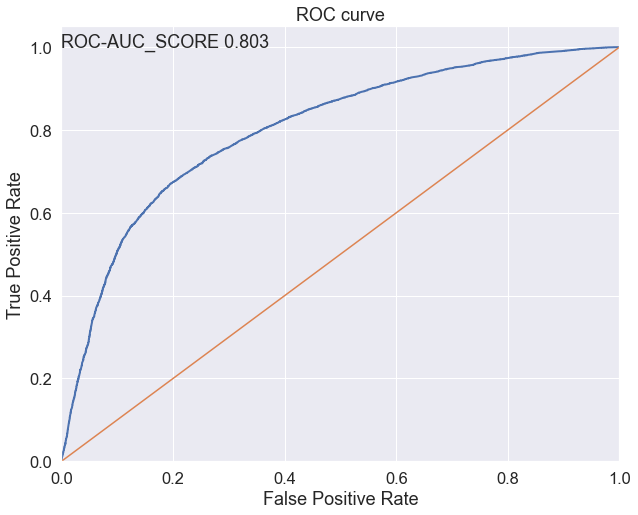

In [26]:

roc_auc_plot(y_test, y_score_boost)

In [27]:
my_dict

{'model': ['LogReg', 'Forest', 'GradBoost'],
 'F-score': [0.7303229695112764, 0.7403956924618081, 0.740185764868887],
 'Precision': [0.6474307596402173, 0.6549401860877271, 0.6673452391968169],
 'Recall': [0.8375576036866359, 0.8514976958525345, 0.8308755760368663],
 'ROC-AUC-SCORE': [0.7840347790421852, 0.8014207145992038, 0.8026012636237291]}

In [28]:
result=pd.DataFrame(my_dict).set_index('model')
result

,F-score,Precision,Recall,ROC-AUC-SCORE
model,,,,
LogReg,0.730323,0.647431,0.837558,0.784035
Forest,0.740396,0.654940,0.851498,0.801421
GradBoost,0.740186,0.667345,0.830876,0.802601


В моем понимании, лучше отработал случайный лес, так как показатель Recall наиболее значимый для данной задачи.